<a href="https://colab.research.google.com/github/piercecharlesf/django-quiz-app/blob/master/looseningTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://www.kaggle.com/datasets/tawsifurrahman/aseptic-loose-hip-implant-xray-database/download?datasetVersionNumber=1"

In [ ]:
data_dir = pathlib.Path("/content/Data")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

206


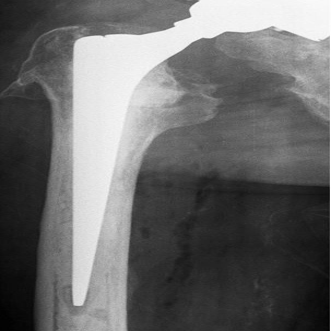

In [ ]:
control = list(data_dir.glob('Control/*'))
PIL.Image.open(str(control[0]))

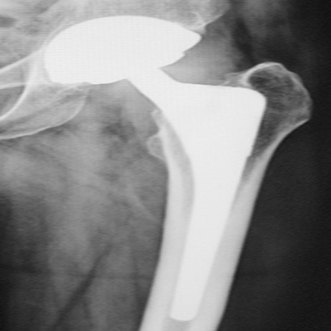

In [ ]:
PIL.Image.open(str(control[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 206 files belonging to 3 classes.
Using 165 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 206 files belonging to 3 classes.
Using 41 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['.ipynb_checkpoints', 'Control', 'Loose']


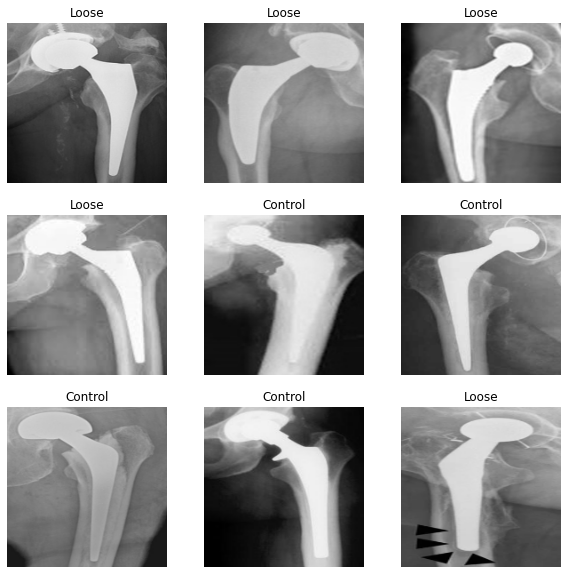

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 6s 881ms/step - loss: 0.8283 - accuracy: 0.4303 - val_loss: 0.6885 - val_accuracy: 0.6829
Epoch 2/10
6/6 [==============================] - 5s 968ms/step - loss: 0.7005 - accuracy: 0.5394 - val_loss: 0.6533 - val_accuracy: 0.6341
Epoch 3/10
6/6 [==============================] - 5s 961ms/step - loss: 0.6914 - accuracy: 0.5515 - val_loss: 0.7186 - val_accuracy: 0.4390
Epoch 4/10
6/6 [==============================] - 5s 823ms/step - loss: 0.6527 - accuracy: 0.6000 - val_loss: 0.6711 - val_accuracy: 0.5122
Epoch 5/10
6/6 [==============================] - 5s 825ms/step - loss: 0.6287 - accuracy: 0.6606 - val_loss: 0.6900 - val_accuracy: 0.4634
Epoch 6/10
6/6 [==============================] - 5s 837ms/step - loss: 0.5074 - accuracy: 0.7697 - val_loss: 0.5642 - val_accuracy: 0.6829
Epoch 7/10
6/6 [==============================] - 6s 1s/step - loss: 0.4842 - accuracy: 0.7939 - val_loss: 0.5957 - val_accuracy: 0.6341
Epoch 8/10
6/6 [=======

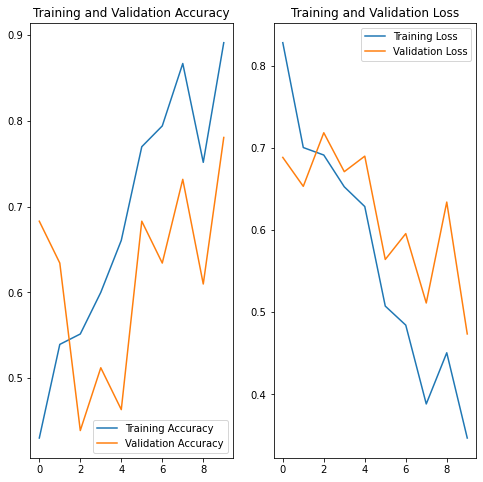

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

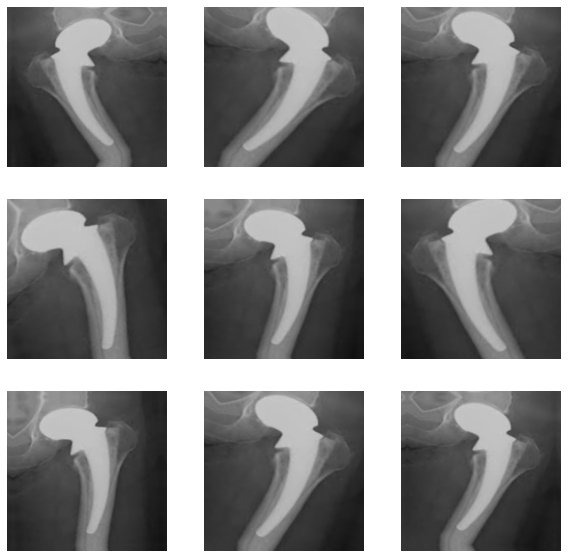

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
6/6 [==============================] - 7s 992ms/step - loss: 0.7845 - accuracy: 0.5333 - val_loss: 0.6738 - val_accuracy: 0.6341
Epoch 2/15
6/6 [==============================] - 6s 956ms/step - loss: 0.7413 - accuracy: 0.4848 - val_loss: 0.7286 - val_accuracy: 0.3902
Epoch 3/15
6/6 [==============================] - 6s 944ms/step - loss: 0.7121 - accuracy: 0.4182 - val_loss: 0.7008 - val_accuracy: 0.4634
Epoch 4/15
6/6 [==============================] - 6s 949ms/step - loss: 0.7213 - accuracy: 0.5333 - val_loss: 0.7920 - val_accuracy: 0.3659
Epoch 5/15
6/6 [==============================] - 6s 942ms/step - loss: 0.7226 - accuracy: 0.5091 - val_loss: 0.6782 - val_accuracy: 0.6341
Epoch 6/15
6/6 [==============================] - 6s 948ms/step - loss: 0.7217 - accuracy: 0.5152 - val_loss: 0.6740 - val_accuracy: 0.6341
Epoch 7/15
6/6 [==============================] - 6s 947ms/step - loss: 0.7204 - accuracy: 0.5212 - val_loss: 0.6793 - val_accuracy: 0.6341
Epoch 8/15
6/6 [====

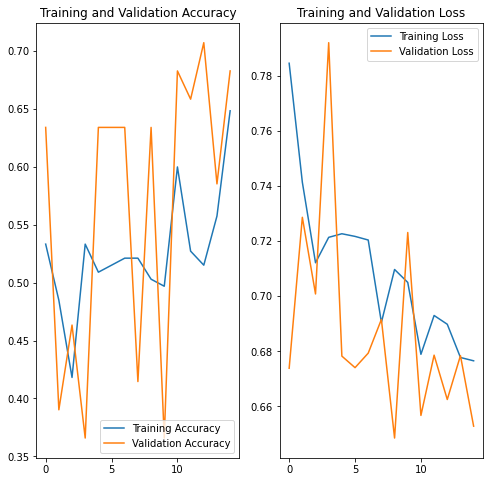

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()